<a href="https://colab.research.google.com/github/Fpinto99/Automized_Learning/blob/main/AA3_TF_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/BUSI/'

zip_path = '/content/drive/MyDrive/BUSI/Dataset_BUSI_Com_Mascaras_Somadas.zip'


Mounted at /content/drive


In [ ]:
import zipfile
zip_path = '/content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_Somadas.zip'
extract_path = '/content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_Somadas'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extração concluída com sucesso! ✅")

In [ ]:

import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn, optim
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, jaccard_score, balanced_accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo usado: {device}")


Dispositivo usado: cuda


In [ ]:
from torchvision.datasets import ImageFolder
from PIL import UnidentifiedImageError

class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except (UnidentifiedImageError, OSError) as e:
            print(f"⚠️ Imagem inválida ignorada: {self.imgs[index][0]}")
            return self.__getitem__((index + 1) % len(self.imgs))

In [ ]:
data_dir = '/content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_Somadas/Dataset_BUSI_Com_Mascaras_Somadas'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Carregar e dividir o dataset
full_dataset = SafeImageFolder(root=data_dir, transform=transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("Classes:", full_dataset.classes)


Classes: ['benign', 'malignant', 'normal']


In [ ]:
#Modelo MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=True)
for param in mobilenet.features.parameters():
    param.requires_grad = False

mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 3)
mobilenet = mobilenet.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 123MB/s]


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=45):
    train_losses = []
    val_accuracies = []
    f1_scores = []
    jaccard_scores = []
    balanced_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        acc = 100. * correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')
        jaccard = jaccard_score(all_labels, all_preds, average='weighted', zero_division=0)
        bal_acc = balanced_accuracy_score(all_labels, all_preds)

        train_losses.append(running_loss)
        val_accuracies.append(acc)
        f1_scores.append(f1)
        jaccard_scores.append(jaccard)
        balanced_accuracies.append(bal_acc)

        print(f"Epoch {epoch+1} | Loss: {running_loss:.4f} | Acc: {acc:.2f}% | F1: {f1:.4f} | Jaccard: {jaccard:.4f} | BalAcc: {bal_acc:.4f}")

    return train_losses, val_accuracies, f1_scores, jaccard_scores, balanced_accuracies

In [ ]:
train_losses, val_accuracies, f1_scores, jaccard_scores, balanced_accuracies = train_model(
    model=mobilenet,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=CrossEntropyLoss(),
    optimizer=optim.Adam(mobilenet.parameters(), lr=0.0001),
    device=device,
    epochs=45
)


⚠️ Imagem inválida ignorada: /content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_Somadas/Dataset_BUSI_Com_Mascaras_Somadas/benign/benign (101).png
Epoch 1 | Loss: 31.7896 | Acc: 55.49% | F1: 0.4306 | Jaccard: 0.3265 | BalAcc: 0.3416
⚠️ Imagem inválida ignorada: /content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_Somadas/Dataset_BUSI_Com_Mascaras_Somadas/benign/benign (101).png
Epoch 2 | Loss: 29.0871 | Acc: 59.98% | F1: 0.4853 | Jaccard: 0.3694 | BalAcc: 0.3829
⚠️ Imagem inválida ignorada: /content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_Somadas/Dataset_BUSI_Com_Mascaras_Somadas/benign/benign (101).png
Epoch 3 | Loss: 26.8374 | Acc: 65.84% | F1: 0.5922 | Jaccard: 0.4561 | BalAcc: 0.4781
⚠️ Imagem inválida ignorada: /content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_Somadas/Dataset_BUSI_Com_Mascaras_Somadas/benign/benign (101).png
Epoch 4 | Loss: 24.5919 | Acc: 70.42% | F1: 0.6652 | Jaccard: 0.5153 | BalAcc: 0.5571
⚠️ Imagem inválida ignorada: /content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_So

In [ ]:
import pandas as pd

mobilenet.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = mobilenet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Gerar relatório como dicionário
report_dict = classification_report(all_labels, all_preds, target_names=full_dataset.classes, output_dict=True)

# Converter para DataFrame
df_report = pd.DataFrame(report_dict).transpose()

# Guardar como CSV
df_report.to_csv("relatorio_classificacao_mobilenet.csv", index=True)

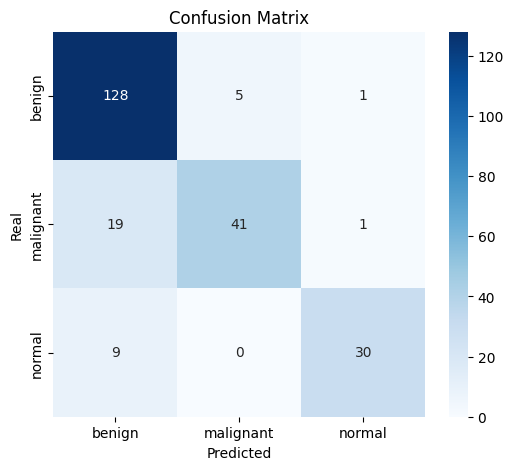

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.show()


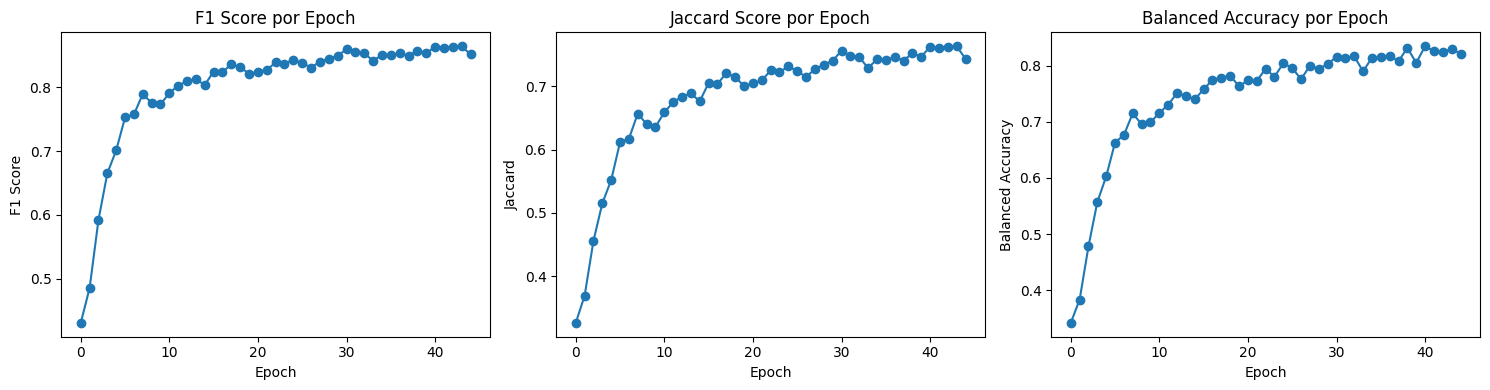

In [ ]:

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(f1_scores, marker='o')
plt.title("F1 Score por Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")

plt.subplot(1, 3, 2)
plt.plot(jaccard_scores, marker='o')
plt.title("Jaccard Score por Epoch")
plt.xlabel("Epoch")
plt.ylabel("Jaccard")

plt.subplot(1, 3, 3)
plt.plot(balanced_accuracies, marker='o')
plt.title("Balanced Accuracy por Epoch")
plt.xlabel("Epoch")
plt.ylabel("Balanced Accuracy")

plt.tight_layout()
plt.show()




In [ ]:
df_f1 = pd.DataFrame({'Epoch': list(range(1, len(f1_scores) + 1)), 'F1 Score': f1_scores})
df_jaccard = pd.DataFrame({'Epoch': list(range(1, len(jaccard_scores) + 1)), 'Jaccard Score': jaccard_scores})
df_balanced = pd.DataFrame({'Epoch': list(range(1, len(balanced_accuracies) + 1)), 'Balanced Accuracy': balanced_accuracies})

# Guardar em CSVs separados
df_f1.to_csv("f1_score_class.csv", index=False)
df_jaccard.to_csv("jaccard_score_class.csv", index=False)
df_balanced.to_csv("balanced_accuracy_class.csv", index=False)

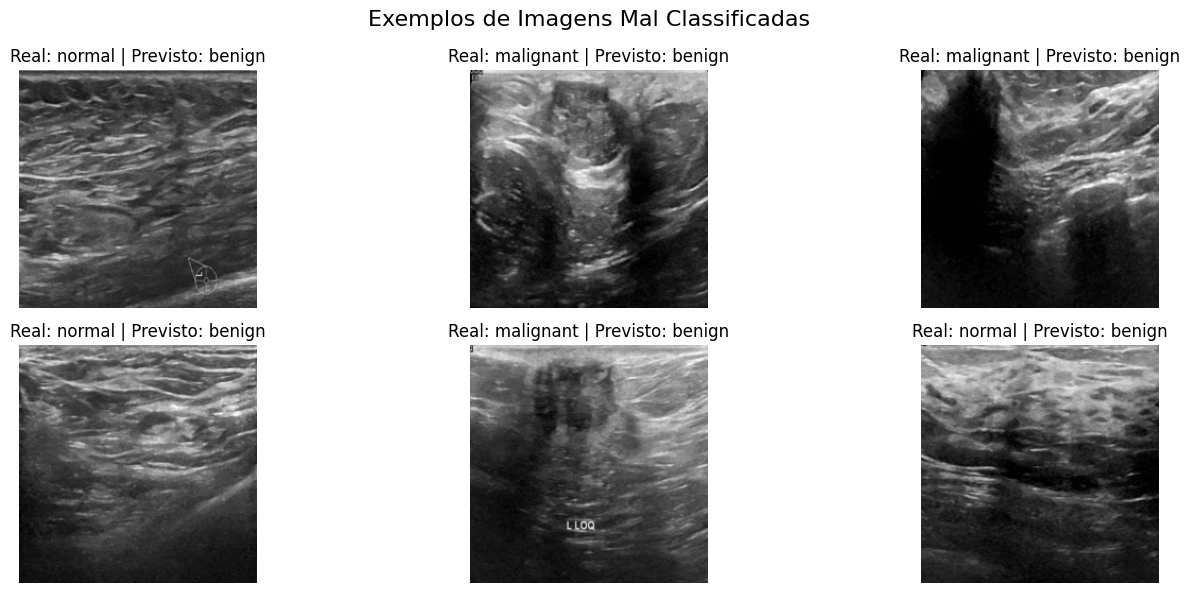

In [ ]:
#Mostrar imagens mal classificadas
misclassified = []

mobilenet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = mobilenet(images)
        _, preds = torch.max(outputs, 1)
        for img, pred, label in zip(images, preds, labels.to(device)):
            if pred != label:
                misclassified.append((img.cpu(), pred.cpu().item(), label.cpu().item()))

plt.figure(figsize=(15, 6))
for i in range(min(6, len(misclassified))):
    img, pred, label = misclassified[i]
    plt.subplot(2, 3, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Real: {full_dataset.classes[label]} | Previsto: {full_dataset.classes[pred]}")
    plt.axis('off')
plt.suptitle("Exemplos de Imagens Mal Classificadas", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
#Exportar previsões para CSV
import pandas as pd

filenames = []
true_labels = []
predicted_labels = []

mobilenet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = mobilenet(images)
        _, preds = torch.max(outputs, 1)
        for i in range(len(images)):
            idx = labels[i].item()
            true_labels.append(full_dataset.classes[labels[i]])
            predicted_labels.append(full_dataset.classes[preds[i]])
            filenames.append("imagem_" + str(len(filenames) + 1))  # Nome fictício

# Criar DataFrame
df_preds = pd.DataFrame({
    "filename": filenames,
    "true_label": true_labels,
    "predicted_label": predicted_labels
})

# Guardar como CSV
df_preds.to_csv("/content/previsoes_teste_classification.csv", index=False)
print("Ficheiro 'previsões_teste_classification.csv' criado com sucesso.")


Ficheiro 'previsões_teste_classification.csv' criado com sucesso.


In [ ]:
from PIL import Image

img = Image.open("/content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_Somadas/Dataset_BUSI_Com_Mascaras_Somadas/benign/benign (101).png")
img.show()

UnidentifiedImageError: cannot identify image file '/content/drive/MyDrive/Dataset_BUSI_Com_Mascaras_Somadas/Dataset_BUSI_Com_Mascaras_Somadas/benign/benign (101).png'